# RECONOCIMIENTO DE EXPRESIONES FACIALES 

Librerias 

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

Cargar dataset 

In [2]:
# Definir carpeta datos y tamaña imagenes
TRAIN_DIR = './data/images/train/'
TEST_DIR = './data/images/test/'
IMG_SIZE = 48
BATCH_SIZE = 32

Visualizacion y normalizacion 

In [3]:
# Funcion mostrar imagenes 
def plot_images(images, labels, rows = 2, cols = 6):
    fig, axes = plt.subplots(rows, cols, figsize = (16, 8))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img, cmap = 'gray')
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
# Funcion cargar imagenes aleatorias 
def load_random_images_from_directory(directory, num_images = 10):
    class_folders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    images = []
    labels = []

# cargar imagenes de cada clase 
    for folder in class_folders:
        class_name = os.path.basename(folder)
        images_files = os.listdir(folder)
        random_files = random.sample(images_files, min(num_images, len(images_files)))

        for file in random_files:
            img_path = os.path.join(folder, file)
            img = load_img(img_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img)
            img_array = img_array / 255
            images.append(img_array)
            labels.append(class_name)

    return images, labels

In [5]:
train_images, train_labels = load_random_images_from_directory(TRAIN_DIR, num_images = 5)

Imágenes de Entrenamiento:


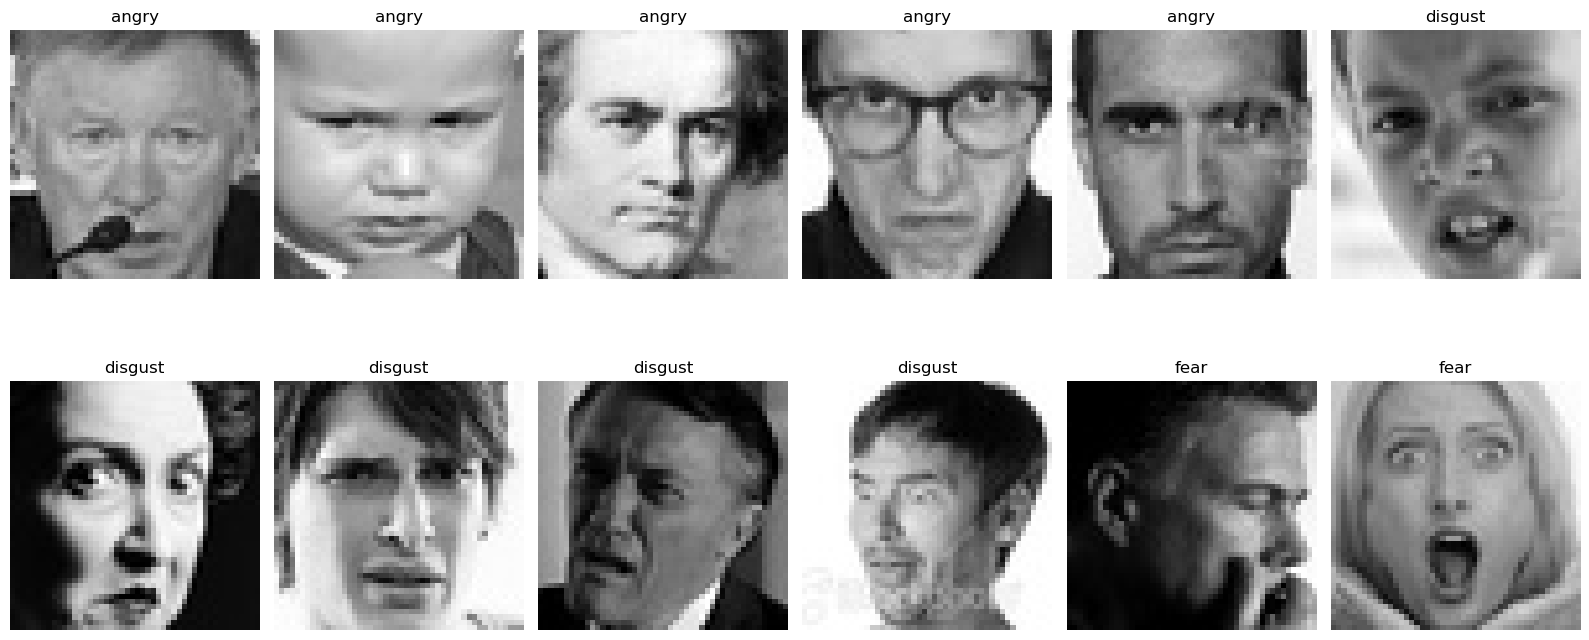

In [6]:
print("Imágenes de Entrenamiento:")
plot_images(train_images, train_labels)

Preprocesamiento de imagenes

In [7]:
# Definir generador datos con aumentacion
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 10, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1, 
    horizontal_flip = True, 
    validation_split = 0.2 
)

test_datagen = ImageDataGenerator(rescale= 1/255)

In [8]:
# Generador imagenes Train
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'training' 
)

Found 23060 images belonging to 7 classes.


In [9]:
# Generacion imagenes Validation 
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'validation' 
)

Found 5761 images belonging to 7 classes.


In [10]:
# Generacion imagenes Test 
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    shuffle = False 
)

Found 0 images belonging to 1 classes.


CONSTRUCCION RED NEURONAL
- Diseñar RN capas adecuadas
- Configurara parametros para entrenamiento 

ENTRENAMIENTO MODELO
- Entrenar modelo 
- Validar modelo y ajustar hiperparametros 

EVALUACION Y PREDICCION
- Evaluar modelo
- Preparar predicciones 